# Download SNOTEL Data Using the API

In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [2]:
# Get SNOTEL Sites
AWDB_API_DOMAIN = "https://api.snowdata.info"

#snotel sites
sntl_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=SNTL&format=geojson"

#cdec sites
msnt_meta_url = f"{AWDB_API_DOMAIN}/stations/getMeta?network=MSNT&format=geojson"

# Get the data and rename everything to match the snow ex columns
gdf_sntl = gpd.read_file(sntl_meta_url).rename(
    columns={"name": "site_name", "stationTriplet": "site_id"}
)
gdf_msnt = gpd.read_file(msnt_meta_url).rename(
    columns={"name": "site_name", "stationTriplet": "site_id"}
)
gdf_sntl = pd.concat([gdf_msnt, gdf_sntl])

In [3]:
gdf_sntl.head()

,actonId,beginDate,countyName,endDate,fipsCountryCd,fipsCountyCd,fipsStateNumber,huc,hud,site_name,shefId,stationDataTimeZone,stationTimeZone,site_id,geometry
0,None,1996-09-01,UNKNOWN,2100-01-01,US,999,96,None,None,Yellowhead Lake,None,None,None,1A01P:BC:MSNT,POINT Z (-118.53333 52.90000 6060.00000)
1,None,1971-10-01,UNKNOWN,2100-01-01,US,999,96,None,None,McBride Upper,None,None,None,1A02P:BC:MSNT,POINT Z (-120.31667 53.30000 5276.00000)
2,None,1968-10-01,UNKNOWN,2100-01-01,US,999,96,None,None,Barkerville,None,None,None,1A03P:BC:MSNT,POINT Z (-121.48333 53.05000 4865.00000)
3,None,1999-09-24,UNKNOWN,2100-01-01,US,999,96,None,None,Hedrick Lake,None,None,None,1A14P:BC:MSNT,POINT Z (-121.00000 54.10000 3668.00000)
4,None,1984-10-01,UNKNOWN,2100-01-01,US,999,96,None,None,Revolution Creek,None,None,None,1A17P:BC:MSNT,POINT Z (-120.36667 53.78333 5499.00000)


In [16]:
sntl_ml = gdf_sntl[gdf_sntl['site_name'] == 'Mesa Lakes']                          

In [15]:
sntl_pr = gdf_sntl[gdf_sntl['site_name'] == 'Park reservoir']  

In [18]:
sntl_gm = pd.concat([sntl_ml, sntl_pr], ignore_index=True)

In [19]:
sntl_gm

,actonId,beginDate,countyName,endDate,fipsCountryCd,fipsCountyCd,fipsStateNumber,huc,hud,site_name,shefId,stationDataTimeZone,stationTimeZone,site_id,geometry
0,08K04S,1985-10-01,Mesa,2100-01-01,US,077,08,140100051307,14010005,Mesa Lakes,MESC2,-8.0,None,622:CO:SNTL,POINT Z (-108.05756 39.05738 10168.00000)


<AxesSubplot:>

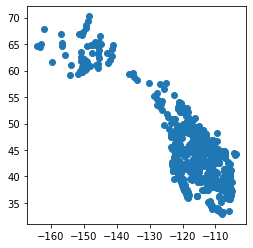

In [10]:
gdf_sntl.plot()

In [13]:
polys = pickle.load(open('../../../data/bounds.pkl', 'rb'))

In [19]:
polys.keys()

dict_keys(['Utica, MT', 'Eldorado National Forest, CA', 'Donner Memorial State Park, CA', 'Rocky Mountains NP, CO', 'Grand Mesa, CO', 'Sierra National Forest, CA', 'Fraser, CO', 'Peeler Peak, CO', 'Silver City, ID', 'Ironton, CO', 'Los Alamos, NM', 'Lowman, CO', 'Salt Lake City, UT'])

In [26]:
sntl_gm = gpd.clip(gdf_sntl, polys['Grand Mesa, CO'])

<AxesSubplot:>

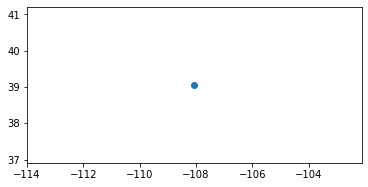

In [27]:
sntl_gm.plot()

In [29]:
sntl_gm

,actonId,beginDate,countyName,endDate,fipsCountryCd,fipsCountyCd,fipsStateNumber,huc,hud,site_name,shefId,stationDataTimeZone,stationTimeZone,site_id,geometry
550,08K04S,1985-10-01,Mesa,2100-01-01,US,077,08,140100051307,14010005,Mesa Lakes,MESC2,-8.0,None,622:CO:SNTL,POINT Z (-108.05756 39.05738 10168.00000)


In [37]:
gdf_sntl = gdf_sntl.to_crs('epsg:32612')

In [33]:
poly_gdf = gpd.GeoDataFrame(polys['Grand Mesa, CO'], index = [0], columns = ['geometry'], crs='epsg:4326')

In [40]:
poly_gdf = poly_gdf.to_crs('epsg:32612')

<AxesSubplot:>

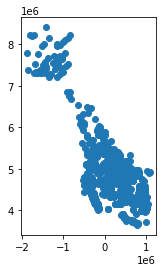

In [41]:
fig, ax = plt.subplots()

gdf_sntl.plot(ax=ax)
poly_gdf.plot(ax=ax)

<AxesSubplot:>

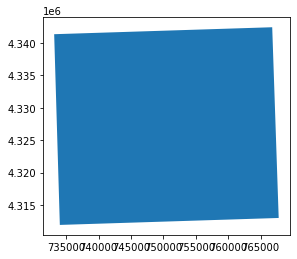

In [44]:
poly_gdf.plot()

In [ ]:
poly_gdf.geometry = poly_gdf.geometry.buffer(2000)

In [ ]:
sntl_gm2 = gpd.clip(gdf_sntl, poly_gdf)

In [ ]:
sntl_gm2

<AxesSubplot:>

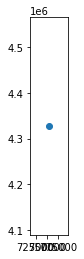

In [58]:
fig, ax = plt.subplots()
sntl_gm2.plot(ax=ax)

In [23]:
# Written by Beau Uriona

# AWDB loader

from datetime import datetime

import requests
import pandas as pd

API_DOMAIN = "https://api.snowdata.info/"

def get_awdb_data(site_ids, element="SNWD", sdate=datetime(1899,10,1), edate=datetime.now(), orient="records", server=API_DOMAIN, sesh=None):
    """
    Takes a list of site ids or a single site id and by default returns SWE period of record data as a single or list of dataframes,
    but user can pass args to modify data returned.
    
    Valid elements include WTEQ, SNWD, PREC, SMS, STO, TAVG
    site_id takes the form of a triplet made from <network_site_id>:<state_abbrv>:<network> where network is either SNTL or MNST
    """
    dfs = []
    return_single = False
    if not isinstance(site_ids, list):
        site_ids = [site_ids]
        return_single = True
    for site_id in site_ids:
        endpoint = "data/getDaily"
        date_args = f"sDate={sdate:%Y-%m-%d}&eDate={edate:%Y-%m-%d}"
        frmt_args = f"format=json&orient={orient}"
        all_args = f"?triplet={site_id}&{date_args}&element={element}&{frmt_args}"
        url = f"{server}{endpoint}{all_args}"
        print(f"getting data for {site_id} {element} starting {sdate:%Y-%m-%d} and ending {edate:%Y-%m-%d}")
        data_col_lbl = f"{site_id}" + ":" + f"{element}"
        if sesh:
            req = sesh.get(url)
        else:
            req = requests.get(url)
        if req.ok:
            df = pd.DataFrame.from_dict(req.json())
            df.columns = ["Date", data_col_lbl]
            df.set_index("Date", inplace=True)
        else:
            print("  No data returned!")
            df = pd.DataFrame(
                data=[
                    {"Date": pd.NaT, data_col_lbl: None}
                ],
            ).set_index("Date").dropna()
        dfs.append(df)
    if return_single:
        return dfs[0]
    return dfs
    

# df = get_awdb_data(site_ids="1099:UT:SNTL", sdate=datetime(2021, 10, 1))
# df

In [24]:
sntl_gm

,actonId,beginDate,countyName,endDate,fipsCountryCd,fipsCountyCd,fipsStateNumber,huc,hud,site_name,shefId,stationDataTimeZone,stationTimeZone,site_id,geometry
0,08K04S,1985-10-01,Mesa,2100-01-01,US,077,08,140100051307,14010005,Mesa Lakes,MESC2,-8.0,None,622:CO:SNTL,POINT Z (-108.05756 39.05738 10168.00000)


In [32]:
gm_sntl_depth = get_awdb_data(site_ids='622:CO:SNTL', sdate=datetime(2018, 10, 1))
df

getting data for 622:CO:SNTL SNWD starting 2018-10-01 and ending 2022-07-13


,622:CO:SNTL:SNWD
Date,
2018-10-01,0.0
2018-10-02,0.0
2018-10-03,0.0
2018-10-04,0.0
2018-10-05,0.0
...,...
2022-07-09,NaN
2022-07-10,NaN
2022-07-11,NaN


In [33]:
out_fp = '../../../data/snotel_depths.pkl'

In [34]:
with open(out_fp, 'wb') as f:
    pickle.dump(gm_sntl_depth, f)

In [35]:
gm_sntl = pickle.load(open(out_fp, 'rb'))

<AxesSubplot:xlabel='Date'>

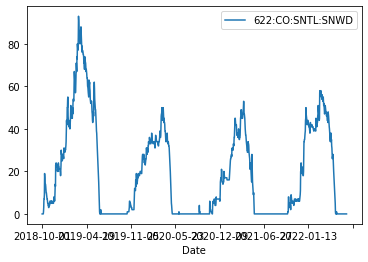

In [36]:
gm_sntl.plot()

In [ ]:
gm_sntl_depth

<AxesSubplot:xlabel='Date'>

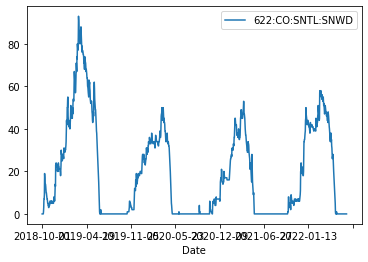

In [31]:
df.plot()

In [29]:
sntl_gm.site_id.astype(str)

0    622:CO:SNTL
Name: site_id, dtype: object

In [ ]:
print(f"The CRS of the Snotel metadata is - {gdf_sntl.crs}, better change it")

In [ ]:
gdf_sntl = gdf_sntl.to_crs(4326) #snow ex planar projection appears to be 26912